# Librerias

In [1]:
import pandas as pd

# Dataset

## Lectura del dataset

In [2]:
df0 = pd.read_parquet("train0.parquet")
df1 = pd.read_parquet("train1.parquet")
df2 = pd.read_parquet("train2.parquet")

In [3]:
df = pd.concat([df0, df1, df2], axis=0)

## Sample del dataset

In [4]:
df.shape

(1785997, 15)

In [5]:
# Se obtiene una muestra del dataset
df_train = df.sample(250000,random_state=42)
df_train.reset_index(drop=True, inplace=True)
df_train.head(5)

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
0,US,48436783,R3VZ6710M771Q7,B000ERVLZ2,506091434,Cars,Video Games,4,0,0,0,1,Nice,A nice racing and adventure games for kids tha...,2012-12-30
1,US,10160659,R1ISCOYUPLYTJV,B001ABN82K,983393989,Guitar Hero World Tour,Video Games,1,6,7,0,0,After four days my guitar malfuncioned,I received this from Amazon on Wednesday after...,2008-11-06
2,US,20284595,R3MTERWLEY377T,B004S5TDL0,792096395,Rocksmith,Video Games,5,0,0,0,1,fantastic,"What can I say, it's gameplay is just amazing,...",2013-04-08
3,US,11717802,R2HFHUC1X14BC,B00DB9JYFY,507112905,Titanfall,Video Games,3,21,39,0,0,it's something.,this is my honest opinion and i hope the devel...,2014-03-12
4,US,38007355,RAPDVMRNV1B82,B000038AAW,666080959,Diablo,Video Games,4,0,4,0,0,diablo is fun,but after a while diablo get s boring all u do...,2002-06-20


In [6]:
df_train['text'] = df_train['review_headline'] + ' ' + df_train['review_body']

# Modelamiento por Arquitecturas

## Naives Bayes

In [7]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay

import re
import nltk
from nltk.corpus import stopwords
stemmer = nltk.stem.SnowballStemmer('english') 
nltk.download('stopwords') 

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\pms_l\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [8]:
def processing_text(texto):
    # Paso 1: Remover con un expresión regular carateres especiales (no palabras).
    processed_feature = re.sub(r'\W', ' ', str(texto))
    # Paso 2: Remover ocurrencias de caracteres individuales
    processed_feature= re.sub(r'\s+[a-zA-Z]\s+', ' ', processed_feature)
    processed_feature = re.sub(r'\^[a-zA-Z]\s+', ' ', processed_feature)
    # Paso 3: Remover números (Ocurrencias muy esporádicas en nuestro dataset)
    processed_feature = re.sub(r'[0-9]+', ' ', processed_feature)
    # Paso 4: Simplificar espacios concecutivos a un único espacio entre palabras
    processed_feature = re.sub(' +', ' ', processed_feature)
    # Paso 5: Pasar todo el texto a minúsculas
    processed_feature = processed_feature.lower()
    # Paso 6: Aplicar stemming. Es una forma de enviar las palabras a una raiz común simplificando de esta manera el vocabulario.
    #         por ejemplo las palabras (absurdo, absurdos) que estan en el review 2895 seran llevados a la raiz común "absurd"
    #         y de esta forma se evita tener dos palabras diferentes con el mismo significado en nuestro vocabulario.
    processed_feature = " ".join([stemmer.stem(i) for i in processed_feature.split()])
    return processed_feature

In [9]:
# texto_para_procesar y labels respectivamente
texto_para_procesar = df_train['text'].values
labels = df_train['star_rating'].values

# El texto ya procesado de cada ejemplo en nuestro dataset lo almacenaremos en la variable "texto_procesado"
texto_procesado = []
for sentence in range(0, len(texto_para_procesar)):
    procesado = processing_text(texto_para_procesar[sentence])
    texto_procesado.append(procesado)

### Representacion 1

In [10]:
# Bolsa de palabras
vectorizer = CountVectorizer(max_features=2500, stop_words=stopwords.words('english'))
# max_features representa el tamaño del vocabulario. Vamos a permitir 2500 palabras.
# stop_words le indicamos las palabras de parada para que las ignore en el vocabulario.

# Ahora le solicitamos utilizando nuestro conjunto de datos que construya el vocabulario y tambien transforme nuestro texto
texto_features = vectorizer.fit_transform(texto_procesado).toarray().astype("float16")

In [11]:
X_train, X_test, y_train, y_test = train_test_split(texto_features, labels, test_size=0.2, random_state=0)

In [12]:
# Ahora entrenemos un modelo simple. Ya conocenos Naive Bayes!!
nb = MultinomialNB()
# El método fit en sklearn permite ejecutar el proceso de entrenamiento.
nb.fit(X_train, y_train)

MultinomialNB()

In [13]:
predictions = nb.predict(X_test)

In [14]:
# Ahora calculamos el score de accuracy enviando las predicciónes y los valores reales de polaridad.
print(accuracy_score(y_test, predictions))

0.64706


In [15]:
## OPCIONAL
## Vamos a profundizar en estos conceptos mas adelante.
cm = confusion_matrix(y_test, predictions,labels=nb.classes_)

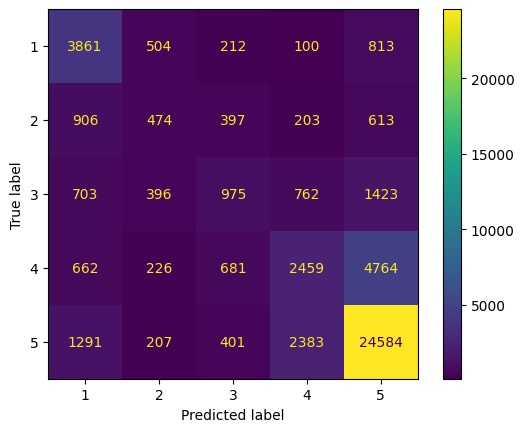

In [16]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=nb.classes_)
disp.plot()

In [17]:
print(classification_report(y_test, predictions, digits=4))

              precision    recall  f1-score   support

           1     0.5201    0.7033    0.5980      5490
           2     0.2623    0.1828    0.2155      2593
           3     0.3657    0.2289    0.2816      4259
           4     0.4163    0.2797    0.3346      8792
           5     0.7635    0.8517    0.8052     28866

    accuracy                         0.6471     50000
   macro avg     0.4656    0.4493    0.4470     50000
weighted avg     0.6159    0.6471    0.6245     50000



### Representacion 2

### Representacion 3

## Logistic Regresion (SDGClassfier)

In [18]:
from sklearn.linear_model import SGDClassifier

### Representacion 1

### Representacion 2


### Representacion 3

## Neuronal Network (Sequencial)

In [19]:
from keras.models import Sequential

### Representacion 1

### Representacion 2

### Representacion 3